In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
import seaborn as sns
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
from tensorflow import keras
from keras import Input, Model, Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Dense, Flatten, InputLayer, Reshape, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

%matplotlib inline

In [5]:
# Dict of labels
categories = {'buildings': 0,
            'forest': 1,
            'glacier': 2,
            'mountain': 3,
            'sea': 4,
            'street': 5 }

# Load images

In [6]:
def load_images(images_folder, imag_size = (128,128), scale=True, pred_set=False):

    # Store paths to images
    image_path = []
    for drnme, _, filenames in os.walk(images_folder):
        for filename in filenames:
            image_path.append(os.path.join(drnme, filename))

    print("There are {} images in {}".format(len(image_path), images_folder))
    
    # Load images and associated labels
    images = []
    labels = []

    for path in tqdm.tqdm(image_path):

        imag = cv2.imread(path, cv2.IMREAD_GRAYSCALE)    
        imag = cv2.resize(imag, imag_size) # Resize the images

        imag = np.array(imag)

        images.append(imag)
        if not pred_set: # pred doesn't have label
            labels.append(categories[path.split('/')[-2]]) # last folder before the image name is the category

    images = np.array(images)  
    images = images.astype(np.int64)
    
    if scale:
        images = images/255 # scale
        
    return image_path, images, np.asarray(labels)

## Training set

In [7]:
import os
imag_size = (125,125)
images_train_folder = '/content/drive/MyDrive/CNN Image classification/seg_train/seg_train'
image_path, itl_images, y_train = load_images(images_train_folder, imag_size=imag_size)

# Resize
itl_images = np.array(itl_images).reshape(-1,125,125,1)
itl_images.shape

There are 14044 images in /content/drive/MyDrive/CNN Image classification/seg_train/seg_train


100%|██████████| 14044/14044 [50:22<00:00,  4.65it/s]


(14044, 128, 128, 1)

## Test set

In [8]:
imag_size = (125,125)
images_test_folder = ('/content/drive/MyDrive/CNN Image classification/seg_test')
_, X_test, y_test = load_images(images_test_folder, imag_size=imag_size)

X_test = np.array(X_test).reshape(-1,125,125,1)
X_test.shape

There are 3000 images in /content/drive/MyDrive/CNN Image classification/seg_test


100%|██████████| 3000/3000 [11:06<00:00,  4.50it/s]


(3000, 128, 128, 1)

Let's take a look at the categories (target values) :

In [9]:
set(y_train)

{0, 1, 2, 3, 4, 5}

So we have classes from 0 to five. 

# Visualizing

Plot some of the images from the train set

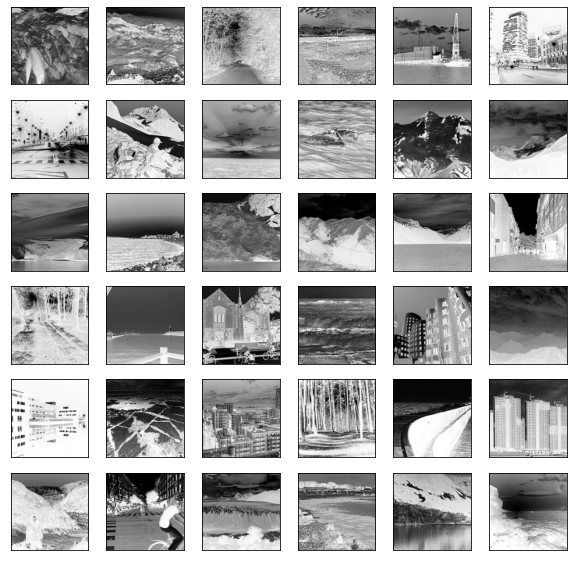

In [10]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(len(image_path),36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(itl_images[image_ind]), cmap=plt.cm.binary)

In [11]:
y_train_df = pd.DataFrame(y_train)
y_train_df.head()

,0
0,5
1,5
2,5
3,5
4,5


How are the categories distributed?

In [12]:
y_train_df.value_counts()

3    2512
2    2404
5    2382
4    2284
1    2271
0    2191
dtype: int64

# Model building

In [13]:
len(categories)

6

In [14]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

def build_cnn_model():
    cnn_model=tf.keras.Sequential([
      Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=itl_images.shape[1:]),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),

      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(0.4),

      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),
        
      Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),
        

      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),
        
      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(0.4),
      Flatten(),

      Dense(units=len(categories),activation='softmax')
    ])

    return cnn_model
  
model = build_cnn_model()
# Initialize the model by passing some data through
model.predict(itl_images[[0]])
# Print the summary of the layers in the model.
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        3

## Plot the model

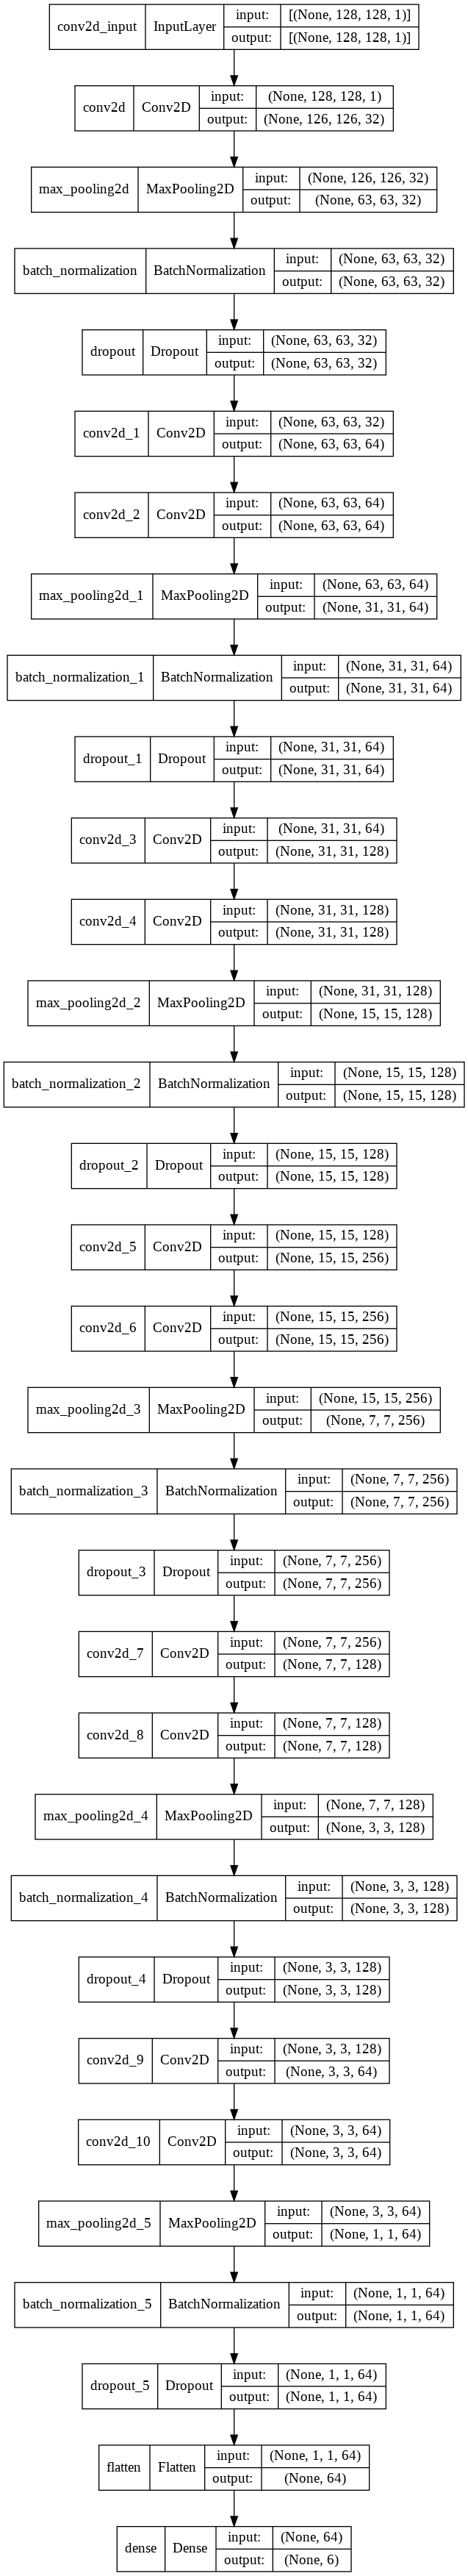

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compile model and proceed to training

In [16]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

### Some callbacks

We add some callbacks to save the weights of the model and for early stopping.

In [17]:
checkpoint_filepath = '/kaggle/working/checkpoint.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq=56300)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    min_delta=0.001, 
    mode='max',
    restore_best_weights=True
)

In [19]:
# itl_images

In [20]:
itl_images[0][0]

array([[0.81568627],
       [0.80392157],
       [0.82352941],
       [0.83137255],
       [0.83921569],
       [0.83137255],
       [0.82745098],
       [0.85490196],
       [0.85882353],
       [0.85098039],
       [0.87058824],
       [0.8627451 ],
       [0.85882353],
       [0.87058824],
       [0.87058824],
       [0.88627451],
       [0.86666667],
       [0.88235294],
       [0.87058824],
       [0.8627451 ],
       [0.86666667],
       [0.88235294],
       [0.87058824],
       [0.87843137],
       [0.87843137],
       [0.88235294],
       [0.87843137],
       [0.87843137],
       [0.89411765],
       [0.89411765],
       [0.89019608],
       [0.88627451],
       [0.90588235],
       [0.89019608],
       [0.89803922],
       [0.89411765],
       [0.89411765],
       [0.89019608],
       [0.90588235],
       [0.90588235],
       [0.91372549],
       [0.90588235],
       [0.90196078],
       [0.90980392],
       [0.90196078],
       [0.9254902 ],
       [0.92156863],
       [0.901

In [21]:
print(itl_images.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(14044, 128, 128, 1)
(14044,)
(3000, 128, 128, 1)
(3000,)


In [22]:
history = model.fit(itl_images, y_train, 
                    batch_size = 128, 
                    epochs = 10, 
                    verbose = 1, 
                    validation_data = (X_test, y_test),
                    callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/10
110/110 [==============================] - 1439s 13s/step - loss: 1.4204 - accuracy: 0.4656 - val_loss: 2.9087 - val_accuracy: 0.1700
Epoch 2/10
110/110 [==============================] - 1447s 13s/step - loss: 0.9063 - accuracy: 0.6581 - val_loss: 7.1926 - val_accuracy: 0.1580
Epoch 3/10
110/110 [==============================] - 1433s 13s/step - loss: 0.7095 - accuracy: 0.7419 - val_loss: 2.8732 - val_accuracy: 0.2410
Epoch 4/10
110/110 [==============================] - 1431s 13s/step - loss: 0.6319 - accuracy: 0.7700 - val_loss: 3.5675 - val_accuracy: 0.4003
Epoch 5/10
110/110 [==============================] - 1428s 13s/step - loss: 0.5767 - accuracy: 0.7922 - val_loss: 2.9551 - val_accuracy: 0.3420
Epoch 6/10
110/110 [==============================] - 1447s 13s/step - loss: 0.5477 - accuracy: 0.8023 - val_loss: 2.8480 - val_accuracy: 0.3853
Epoch 7/10
110/110 [==============================] - 1446s 13s/step - loss: 0.5010 - accuracy: 0.8206 - val_loss: 0.9286 - val_ac

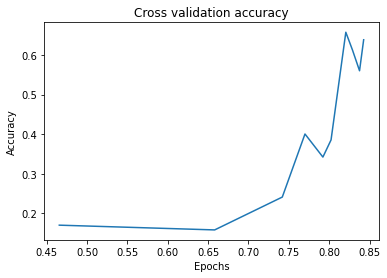

In [18]:

plt.plot(epochs, val_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Cross validation accuracy")
plt.show()

### Plot the performances

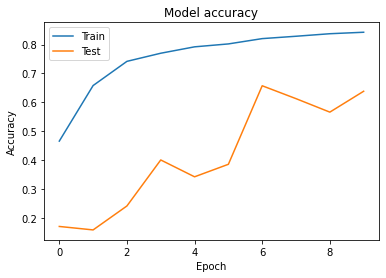

In [23]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

Plotting Model Loss

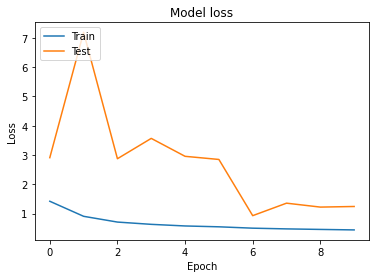

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

# Predict on new data

In [25]:
def predict_class(imag):
    # Resize
    imag = imag.reshape(1,128,128,1)
    # Predict
    predictions = model.predict(imag)
    true_prediction = [tf.argmax(pred) for pred in predictions]
    true_prediction = np.array(true_prediction)
    
    # Return label corresponding to predicted index
    return list(categories.keys())[list(categories.values()).index(true_prediction)]
    

In [26]:
images_pred_folder = ('/content/drive/MyDrive/CNN Image classification/seg_pred/seg_pred')
_, X_pred, y_pred = load_images(images_pred_folder, imag_size=imag_size, scale=True, pred_set=True)

X_pred = np.array(X_pred).reshape(-1,128,128,1)
X_pred.shape

There are 7301 images in /content/drive/MyDrive/CNN Image classification/seg_pred/seg_pred


100%|██████████| 7301/7301 [28:14<00:00,  4.31it/s]


(7301, 128, 128, 1)

In [27]:
y_pred.shape

(0,)

In [28]:
y_pred

array([], dtype=float64)

In [29]:
X_pred[0].shape

(128, 128, 1)

In [30]:
predict_class(X_pred[0])

'sea'

In [31]:
X_pred.shape

(7301, 128, 128, 1)

### Plot some images and predicted labels

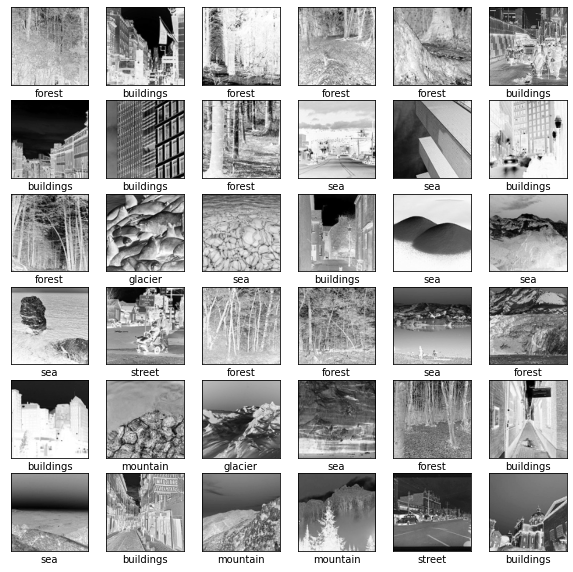

In [32]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(X_pred.shape[0],36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_pred[image_ind]), cmap=plt.cm.binary)
    
    # Predict and get label
    label = predict_class(X_pred[image_ind])
    plt.xlabel(label)

### Save the model

In [33]:
model.save("intel_image_classifier.h5")

In [39]:
model_preds = model.predict(X_test)
model_preds=np.argmax(model_preds,axis=1)
model_preds.shape

(3000,)

In [40]:
y_test.shape

(3000,)

In [42]:
y_test[0]

0

In [43]:
model_preds[0]

4

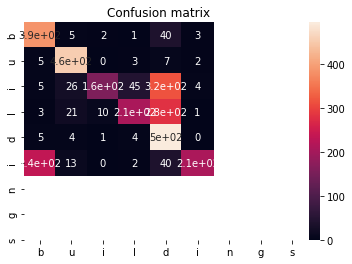

In [84]:
Con_Mat = CM(y_test, model_preds)
ax = plt.axes()
sns.heatmap(Con_Mat, annot=True, 
           annot_kws={"size": 10}, 
           x_labels=label, 
          y_labels=label, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

# Accuracy score

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model_preds)

0.6383333333333333

Image Classification using Alexnet

In [51]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.io import read_image

Preprocessing train and test datasets
Calculating mean and standard deviation of dataset

In [ ]:
ds = datasets.ImageFolder(images_train_folder, transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
]))

loader = DataLoader(ds, batch_size=1000)
mean_list = []
std_list = []

for data in loader:
    numpy_image = data[0].numpy()
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    np.concatenate(mean_list , batch_mean)

    mean_list.append(batch_mean)
    std_list.append(batch_std)
    mean_list = np.array(mean_list).mean(axis=0)
    std_list = np.array(std_list).mean(axis=0)

del ds, loader

In [60]:
# Mean and Standard Deviation of dataset
print("Mean:", mean_list, "Std:", std_list)

Mean: [0.45174545, 0.45953923, 0.46254754] Std: [0.26963392, 0.26880658, 0.28966534]


In [61]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_list, std=std_list)
])

trainset = datasets.ImageFolder(images_train_folder, transform = transform)
testset = datasets.ImageFolder(images_test_folder, transform = transform)

In [62]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True) 
test_loader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [63]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(repr(device))

# Define AlexNet model
class AlexNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(4096, num_classes)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

device(type='cpu')


In [64]:
from tqdm import tqdm

# Define function for checking accuracy
def evaluate_model(loader, criterion, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # Switch model to evaluation mode

    with torch.no_grad():  # We don't need to compute gradients here
        for x, y in tqdm(loader, ascii=".>=", desc="=> Evaluating"):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            loss = criterion(scores, y)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)  # predictions.shape[0]
        
        accuracy = (num_correct / num_samples)
        print(f"=> Loss: {loss.item(): .3f} - Accuracy: {accuracy.item(): .3f}")

    # Switch back to training mode
    model.train()
    return loss.item(), accuracy.item()

# Load and save checkpoint
def save_checkpoint(state, filename="alexnet_chkpoint.pth.tar"):
    print("=> Saving checkpoint...")
    torch.save(state, filename)

def load_checkpoint(model, optimizer, checkpoint):
    print("=> Loading checkpoint...")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [65]:
num_classes = len(classes)

# Initialize network
model = AlexNet(input_channels=3, num_classes=num_classes).to(device)

learning_rate = 0.0001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Load weights and parameters from checkpoint if available
load_model = False
if load_model:
    load_checkpoint(model, optimizer, torch.load("alexnet_chkpoint.pth.tar"))

In [66]:
# Train network
print("Training started...")
num_epochs = 10
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    if epoch != 0 and epoch % 5 == 0:
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
    
    num_correct = 0
    num_samples = 0
    
    loop = tqdm(enumerate(train_loader), total=len(train_loader), ascii=".>=")
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward step
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward step
        optimizer.zero_grad()  # To clear out previous step's gradients
        loss.backward()

        # Gradient descent
        optimizer.step()
        
        # Calculate ratio of correct predictions
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)  # predictions.shape[0]
        
        # Update loss and accuracy on progress bar
        accuracy = (num_correct / num_samples)
        loop.set_description(f"=> Epoch {epoch + 1}/{num_epochs}")
        loop.set_postfix(loss=loss.item(), accuracy=accuracy.item())
    
#     # Compute accuracy at the end of epoch
#     accuracy = (num_correct / num_samples) * 100
#     print(f"=> Epoch {epoch} / {num_epochs}: Loss - {loss.data: .5f}   "
#             f"Accuracy - {num_correct} / {num_samples} = {accuracy:.2f}%")
    
    # Compute test loss and accuracy
    test_loss, test_acc = evaluate_model(test_loader, criterion, model)
    
    train_losses.append(loss.item())
    train_accs.append(accuracy.item())
    
    test_losses.append(test_loss)
    test_accs.append(test_acc)


Training started...


=> Evaluating: 100%|==========| 24/24 [01:36<00:00,  4.01s/it]


=> Loss:  2.966 - Accuracy:  0.151


=> Evaluating: 100%|==========| 24/24 [01:34<00:00,  3.96s/it]


=> Loss:  3.816 - Accuracy:  0.133


=> Evaluating: 100%|==========| 24/24 [01:35<00:00,  3.98s/it]


=> Loss:  4.524 - Accuracy:  0.167


=> Evaluating: 100%|==========| 24/24 [01:34<00:00,  3.95s/it]


=> Loss:  4.357 - Accuracy:  0.151


=> Evaluating: 100%|==========| 24/24 [01:38<00:00,  4.09s/it]


=> Loss:  4.057 - Accuracy:  0.117
=> Saving checkpoint...


=> Evaluating: 100%|==========| 24/24 [01:38<00:00,  4.10s/it]


=> Loss:  4.554 - Accuracy:  0.145


=> Evaluating: 100%|==========| 24/24 [01:37<00:00,  4.04s/it]


=> Loss:  3.987 - Accuracy:  0.152


=> Evaluating: 100%|==========| 24/24 [01:37<00:00,  4.05s/it]


=> Loss:  4.949 - Accuracy:  0.152


=> Evaluating: 100%|==========| 24/24 [01:36<00:00,  4.00s/it]


=> Loss:  5.256 - Accuracy:  0.174


=> Evaluating: 100%|==========| 24/24 [01:36<00:00,  4.02s/it]

=> Loss:  5.917 - Accuracy:  0.128


In [67]:
print("Test Accuracy:")
test_loss, test_acc = evaluate_model(test_loader, criterion, model)

Test Accuracy:


=> Evaluating: 100%|==========| 24/24 [01:37<00:00,  4.05s/it]

=> Loss:  7.028 - Accuracy:  0.128


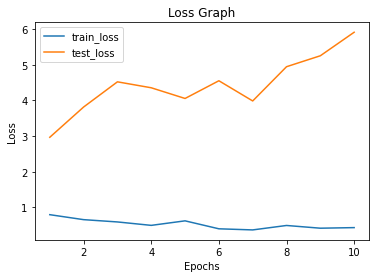

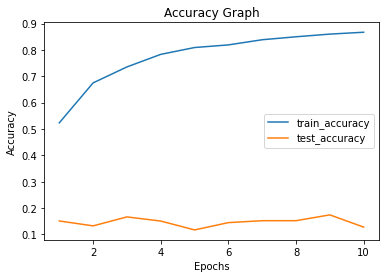

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, num_epochs + 1), train_losses, label='train_loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='test_loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(2, num_epochs + 1, 2))
plt.legend()
plt.show()



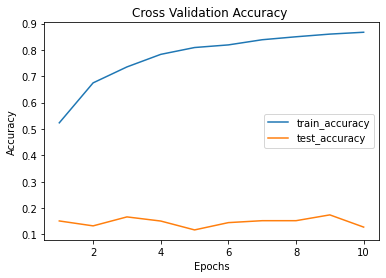

In [70]:
plt.plot(range(1, num_epochs + 1), train_accs, label='train_accuracy')
plt.plot(range(1, num_epochs + 1), test_accs, label='test_accuracy')
plt.title('Cross Validation Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(2, num_epochs + 1, 2))
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        if idx < 5:
            # Retrieve item
            item = batch[0]
            image = item[0]
            true_target = classes[batch[1][0]]

            # Generate prediction
            prediction = model(image.reshape(1, 3, 224, 224).to(device))

            # Predicted class value using argmax
            predicted_class = classes[np.argmax(prediction.cpu())]

            # Reshape image
            image = (image.permute(1, 2, 0) * std_list) + mean_list

            # Show result
            plt.imshow(image)
            plt.title(f'Predicted: {predicted_class} - Actual: {true_target}')
            plt.axis('off')
            plt.show()

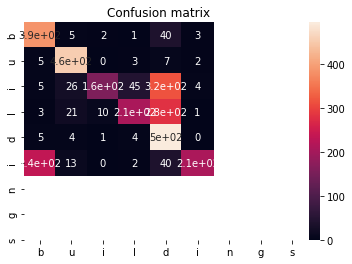

In [85]:
Conf_mat = CM(true_target, predictions)
ax = plt.axes()
sn.heatmap(Conf_mat, annot=True, 
           annot_kws={"size": 10}, 
           x_labels=classes, 
          y_labels=classes, ax = ax)
ax.set_title('Confusion matrix')
plt.show()